# Task $n^\circ$ 1 

#### Requirements:
To correctly run the script <code>qiskit</code>, <code>matplotlib</code>, <code>pylatexenc</code>, <code>ipynb</code> and <code>ipywidgets</code> have to be installed. 

#### Description:
Similarly to the [Draper](https://docs.microsoft.com/en-us/azure/quantum/user-guide/libraries/standard/algorithms) *adder* we use the phase space to add n numbers to filter the results upon the required number.

#### Inputs:
<ol>
    <li> <code>numbers</code>: list of integers </li>
    <li> <code>solution</code>: the number we want our sums to be equal to </li>
    <li> <code>method</code>: a string selecting the method to create the combinations </li>
        </ol>
        
        
#### Explanation of the algorithm:
The algorithm has 2 registers:
<ol>
  <li> To create the combinations of items from <code>numbers</code>, which requires as many qubits as the length of the list</li> 
  <li> To collect the possible sums of the combinations of items from <code>numbers</code>. Its length is $=\log_2\left(\sum_{i\in numbers} i\right)$</li> to be able to describe any possible combination.
</ol>
   

The **SEL** gate select the set of combinations we want to test. We implemented the *Hadamard transform* $=\sum_{i=0}^{2^n}|i\rangle$ (namely all the possible combinations) the *W state* $=\sum_{\ell=0}^{n-1}|1\rangle_\ell\otimes |0\rangle_{(\ell)}$ [<sup id="fn1-back">1</sup>](#fn1 "meaning of (\ell)")(one number at a time) or *W state+X* $=\sum_{\ell=0}^{n-1}|0\rangle_\ell\otimes |1\rangle_{(\ell)}$  (neglecting one number at a time).
In this way, we create an overlap of some possible combinations of items from <code>numbers</code> on the $1^{st}$ register. 

Instead of using the *Draper adder* to sum 2 numbers, we used the second addendum to store the different sums. On the other hand, the first term is 'virtual': it is encoded in the CPs activated from the qubits of the $1^{st}$ register.

To better understand how the algorithm works, let us consider an example.

For instance if we have <code>numbers=[3,2,1]</code> the first number to implement is $3=2^1+2^0$. So, to implement the $2^1$, from the $1^{st}$ qubit of the $1^{st}$ register we apply a $CP(\pi/2)$ on the second last qubit of the $2^{nd}$ register (the $5^{th}$) and a $CP(\pi/4)$ on the $4^{th}$ qubit of the $2^{nd}$ register: $CP_{(1,5)}(\pi)CP_{(1,4)}(\pi/2)$. Likewise, to implement the $2^0$ we will apply $CP_{(1,6)}(\pi)CP_{(1,5)}(\pi/2)CP_{(1,4)}(\pi/4)$. 
In this way the first addendum is 'virtual', it is embedded in this procedure.
Then we iterate the same for the $2$ and the $1$. 

In correspondance to $|1--\rangle$, we are adding to the $2^{nd}$ register the state:
\begin{equation}
\begin{split}
\otimes_{k=0}^{n}\frac{1}{\sqrt{2}}\left(|0\rangle_k + e^{2\pi i (3/2^k)}|1\rangle_k\right) = & \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1} e^{2\pi i (3j)/2^n}|j\rangle\\ 
= & \frac{1}{\sqrt{8}}\left(|000\rangle + e^{2\pi i (3/8)}|001\rangle+e^{2\pi i (6/8)}|010\rangle+e^{2\pi i (9/8)}|011\rangle\\+e^{2\pi i (12/8)}|100\rangle+e^{2\pi i (15/8)}|101\rangle+e^{2\pi i (2/8)}|110\rangle+e^{2\pi i (5/8)}|111\rangle\right)\\
= & QFT|3\rangle
\end{split}
\end{equation} 
where $n$, the number of items in the list, is $n=3$. 

In the same way, with $|-1-\rangle$, we will add $QFT|2\rangle$ and then with $|--1\rangle$, $QFT|1\rangle$.

In correspondence of the state $|101\rangle$ in the $1^{st}$ register, the second register will be in
$$\otimes_{k=0}^{n=3}\frac{1}{\sqrt{2}}\left(|0\rangle_k + e^{2\pi i \left((3/2^k)+(1/2^k)\right)}|1\rangle_k\right)= \otimes_{k=0}^{n=3}QFT(3+1)$$
therefore, by appling a $QFT^\dagger$ to the $2^{nd}$ register, we get $(3+1)$, namely the state $|101\rangle\otimes |4\rangle$.


The initial <code>QFT</code> is replaced by a **H transform** since the input on the $2^{nd}$ register is zero.

Finally, the required number (<code>solution</code>) could be converted into binary and implemented on the second register (appling <code>X</code>s in correspondence of $1$s), to filter the states equal to zero.

Anyway, this procedure requires an extra layer on the quantum circuit that can be replaced at zero cost by directly filtering the states equal to <code>solution</code> obtained on the $2^{nd}$ register.


[<sup id="fn1">1</sup>](#fn1-back) where $(\ell)$ means all qubits execept the $\ell^\text{th}$

## Import the libraries:
(tools.ipynb has to be in the same folder as adder)

In [1]:
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister
import qiskit.quantum_info as qi

import math
import numpy as np
from qiskit.visualization import plot_histogram
from ipynb.fs.full.tools import adder, qft_1, count, w, sel

## Insert the set of numbers and the sum we want to find:

In [2]:
numbers = [5,7,8,9,1,2,3,4,5,6]
solution = 16
method = ['hilbert', 'w state', 'w state+x'][0]

## Initialise the circuit:

In [3]:
# filter numbers bigger than the final solution we want
numbers = list(filter(lambda x: x <= solution, numbers))

# compute the number of required qubits
sum_num = sum(numbers)
bit_sum = int(np.log2(sum_num)) + 1
n = len(numbers) + bit_sum

qr = QuantumRegister(len(numbers), 'q')
qa = QuantumRegister(bit_sum, 'a')
qc = QuantumCircuit(qr, qa)

In [4]:
# implement the SEL gate
qc.sel(len(numbers), method)
# implement the Hadamard transform
qc.h(qa)
# implement the c-P gates
qc.adder(bit_sum, numbers)
# implement the QFT-1
qc.qft_1(qa)
# extract the measure
counts = count(qc)
# filter the states equal to 'solution'
filtered = [(k[bit_sum:], v) for k, v in counts.items() if k[:bit_sum] == ('{0:0'+str(bit_sum)+'b}').format(solution)]

In [5]:
print('Solutions:')
for sol in filtered:
    combination = []
    for i in range(len(numbers)):
        if sol[0][i] == '1':
            combination.append(str(numbers[::-1][i]))
    print('-> ', '+'.join(combination))

Solutions:
->  6+4+1+5
->  4+3+9
->  4+7+5
->  6+5+5
->  4+2+1+9
->  5+2+1+8
->  5+4+7
->  6+1+9
->  5+3+8
->  1+8+7
->  3+1+7+5
->  6+2+1+7
->  5+3+2+1+5
->  2+1+8+5
->  2+9+5
->  4+3+2+7
->  5+2+9
->  6+5+3+2
->  5+4+2+5
->  6+3+7
->  6+5+4+1
->  4+3+1+8
->  5+3+1+7
->  6+4+3+2+1
->  3+8+5


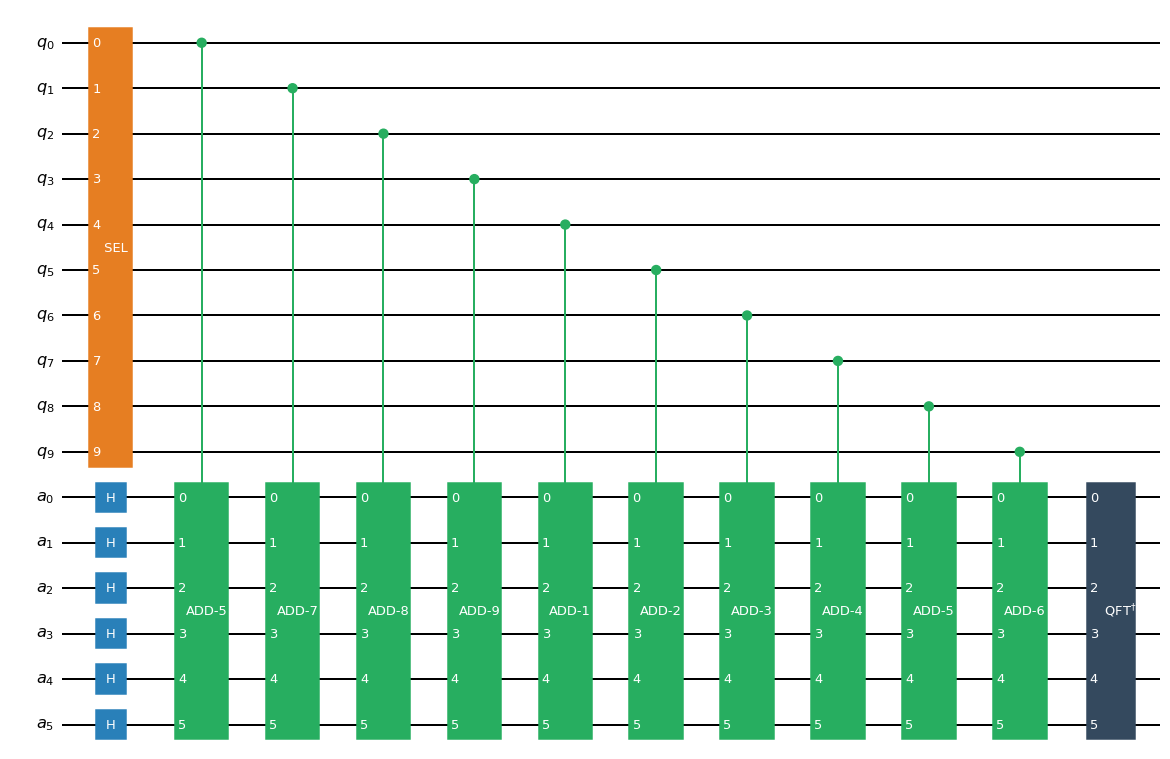

In [6]:
style = {'displaycolor': {'qtf-1':   ('#34495E', '#FFFFFF'),
                          (' SEL '):   ('#E67E22', '#FFFFFF'),
                          'h':   ('#2980B9', '#FFFFFF'),},
         'displaytext' : {'qtf-1': "\quad \mathrm{QFT}^{\dagger}."},
         'gatefacecolor' : '#27AE60',
         'gatetextcolor' : '#FFFFFF'}
qc.draw(output='mpl', style=style)

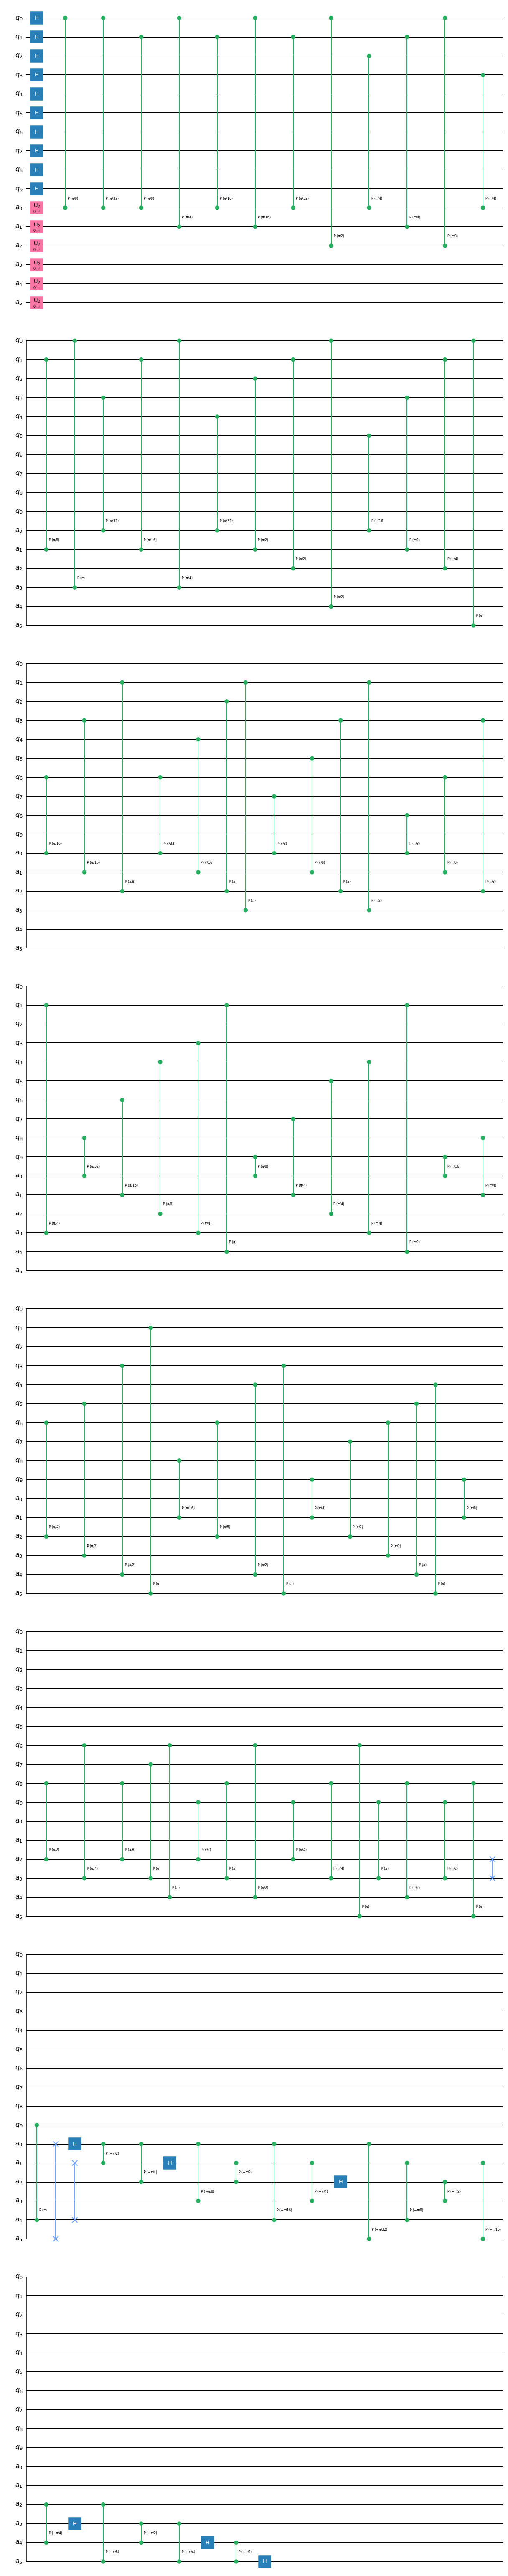

In [7]:
qc.decompose().draw(output='mpl', style=style)

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table